In [1]:
import numpy as np
import os.path

from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
#data_gen = ImageDataGenerator(samplewise_center=True, rescale=1./255)

# from sklearn.model_selection import train_test_split

In [3]:
DIR = "./"#"/Users/skmohan/Workspace/python/jupyter-notebook/udacity-deeplearning/"

def load_npy(prefix):
    xs = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_img.npy".format(prefix)))
    labels = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_labels.npy".format(prefix)))
    # RGB => Grayscale
    xs = np.dot(xs, [0.299, 0.587, 0.114]).reshape(xs.shape[0], 32, 32, 1)  * 1./255 
    # can this be done by generator?
    xs -= xs.mean(axis=0)
    # getting length only for now
    digits_len = to_categorical( np.array(list(map(len, labels)) , dtype=np.int), num_classes=7 )
    padded_labels = np.array(list(map(lambda x: list("{:0>6}".format(x)), labels) ) ).astype(np.int)
    digits = to_categorical(padded_labels).reshape(-1, 6, 10) # 6 digits, 10 classes
    #padded_labels = list(map(lambda x: list("{:0>6}".format(x))[-1], labels) ) 
    #last_digit = to_categorical( padded_labels,num_classes=10)
    ys = [digits_len,] + [ digits[:, i, :] for i in range(6)]
    return xs, ys
    
def load_data():
    x_train, y_train = load_npy("train")
    x_test, y_test = load_npy("test")
    return x_train, y_train, x_test, y_test


In [4]:
x_train, y_train, x_test, y_test = load_data()

3 [0, 0, 0, 1, 2, 8]


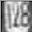

In [5]:
from keras.preprocessing.image import array_to_img
print(np.argmax(y_train[0][8]), [np.argmax(y_train[i+1][8]) for i in range(6)])
array_to_img(x_train[8])

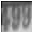

In [6]:
array_to_img(x_test[6424])

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape, Input, Dot
# X_single, y_single = load_npy("test_single")
from keras.regularizers import l2

regularizer = l2()
img_input = Input(shape=(32,32,1))

cnn = Sequential()
cnn.add(Conv2D(16, (5, 5), padding="same", input_shape=(32, 32, 1), kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Dropout(0.5))

cnn.add(Conv2D(32, (5, 5),  padding="same", kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Dropout(0.5))

cnn.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))

cnn = cnn(img_input)
flat = Flatten()(cnn)

size = Dense(1024, kernel_regularizer=regularizer)(flat)
size = Activation('relu') (size)
size = Dropout(0.5) (size)
size = Dense(7, kernel_regularizer=regularizer)(size)
size_output = Activation('softmax', name="Length_Smax")(size)

size_input = Input(shape=(7,))

digit_inputs = []
digit_outputs = []
digits_merged = []

# FIXME use RNN
for i in range(6):
    digit_output = Dense(10, kernel_regularizer=regularizer)(flat)
    digit_output = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(digit_output)
    digit_input = Input(shape=(10,))
    
    digit_inputs.append(digit_input)
    digit_outputs.append(digit_output)


In [145]:
# sample = 12942
# y_pred[0][sample][1] *  y_pred[6][sample][9]

# import tensorflow as tf

# inputs = [ y_pred[i][sample:sample+1] for i in range(7) ] + [y_test[i][sample: sample+1] for i in range(7) ]
# input_tensor = [ tf.convert_to_tensor(i, tf.float64) for i in inputs ]

# with tf.Session() as sess:
#     K.set_session(sess)
#     prob = sequence_probability(input_tensor)
#     res = sess.run(prob)

# res

array([[ 0.01763561]])

In [116]:
from keras import backend as K

def sequence_probability(inputs):
    #y_pred, y_true = inputs
    len_pred, *digits_pred = inputs[:7]
    len_true, *digits_true = inputs[7:]

    n_digits = 6
    
    pS = K.ones_like( len_true[:, 0] )
    b = K.zeros_like( len_true[:, 0] )
    ones = K.ones_like( len_true[:, 0])
    
    for i in range(n_digits):
        b += len_true[:, - (i+1)]
        ps = K.sum(digits_true[i] * digits_pred[i], axis=1)
        pS = pS * ( ones - b + ps * b )
    ps = K.sum( len_pred * len_true, axis=1)
    pS = pS * ps
    return K.reshape(pS, (-1,1))
    # return pS


In [11]:
from keras.layers import merge

y_pred = [size_output,] + digit_outputs
y_true = [size_input,] + digit_inputs

prob_output = merge(y_pred + y_true, mode=sequence_probability, output_shape=(1,), name="Last")
#prob_output = Reshape((1,))(prob_output)

/Users/skmohan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/skmohan/.virtualenv/tensorflow/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [12]:
from keras.optimizers import Adam

adam = Adam(decay=0.05)

In [13]:
from keras.models import Model

# use this for training
model = Model(inputs=[img_input, size_input] + digit_inputs, outputs=prob_output)

# use this to predict
estimator = Model(inputs=[img_input], outputs=[size_output,] + digit_outputs)

model.compile(loss="binary_crossentropy",
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 4, 4, 64)      64960                                        
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1024)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          1049600                                      
___________________________________________________________________________________________

In [35]:
# use this to predict
estimator = Model(inputs=[img_input], outputs=[size_output,] + digit_outputs)


In [14]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

callbacks = [TensorBoard(log_dir='./logs/logs-20170820-1/'),
             EarlyStopping(patience=5),
             ModelCheckpoint("./best_model_20170820.h5", save_best_only=True)]

In [ ]:
model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=100,
          initial_epoch=50,
          callbacks=callbacks)

In [25]:
print("hello.")

hello.


In [17]:
def digit_loss(y_true, y_pred):
    loss = np.ones(y_true[0].shape[0])
    for digit_pred, digit_true in zip(y_pred, y_true):
        loss  = loss *  (digit_pred * digit_true).sum(axis=1)   
    return loss

def accuracy_single(y_true, y_pred):
    total_digits = 0
    correct_digits = 0
    for i in range(1,6):
        samples = np.argmax(y_true[0], axis=1) == i
        size = y_true[0][samples].shape[0]
        total_digits += size * i
        for j in range(6-i, 6):
            digit_true = np.argmax(y_true[j+1][samples], axis=1)
            digit_pred = np.argmax(y_pred[j+1][samples], axis=1)
            correct_digits += (digit_true == digit_pred).sum()
    #print("Digit Accuracy: {} / {} ({:.2%})".format(correct_digits, total_digits, correct_digits/total_digits))
    return correct_digits, total_digits

def accuracy_multi(y_true, y_pred):
    n = y_true[0].shape[0]
    seq_len = np.argmax(y_pred[0], axis=1) #[samples]

    seq_pred = np.sum( [ (seq_len > 6 - i)
                            * np.argmax(y_pred[i], axis=1) 
                            * 10**(6-i) for i in range(1,7) ], 
                axis=0)
    seq_true = np.sum([ np.argmax(y_true[i], axis=1) * 10**(6-i) for i in range(1,7)], axis=0)
    return (seq_pred == seq_true).sum(), n

def performance(y_true, y_pred):
    loss = digit_loss( y_true[1:], y_pred[1:] )
    print("Loss : {}".format( np.product(loss))) # XXX Not sure what this means
    correct_digits, total_digits = accuracy_single(y_true, y_pred)
    print("Accuracy (single): {:.2%} ({}/{})".format(correct_digits/total_digits, correct_digits, total_digits))
    correct_seq, total_seq = accuracy_multi(y_true, y_pred)
    print("Accuracy (seq): {:.2%} ({}/{})".format(correct_seq/total_seq, correct_seq, total_seq))

In [64]:
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)

Loss : 0.8448608967406024
Accuracy (single): 88.52% (64840/73251)
Accuracy (seq): 86.12% (28767/33402)


In [25]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Loss : 0.5676108946827677
Accuracy (single): 73.88% (19232/26032)
Accuracy (seq): 60.15% (7861/13068)


In [67]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Loss : 0.0
Accuracy (single): 76.82% (19997/26032)
Accuracy (seq): 64.22% (8392/13068)


In [84]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Loss : 0.0
Accuracy (single): 45.02% (11719/26032)
Accuracy (seq): 15.36% (2007/13068)


In [38]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Loss : 0.0
Accuracy (single): 32.49% (8459/26032)
Accuracy (seq): 10.09% (1318/13068)


In [22]:
#samples = [ 3373, 2260, 3371, 7716, 6664, 10507, 8507] 
from IPython.display import display
from keras.preprocessing.image import array_to_img

def review(X_true, y_true, nsamples=5, samples=None):
    if samples is  None:
        samples = np.random.choice(X_true.shape[0], nsamples)

    print("Samples: ", samples)
    y_pred = estimator.predict(X_true[samples])
    y_true_ = [ y_true[i][samples] for i in range(7) ]

    performance( y_true_, y_pred)

    for s,sample in enumerate(samples):
        size_pred = np.argmax( y_pred[0][s] )
        num_pred = "".join(map(str, [np.argmax(y_pred[i+1][s]) for i in range(6 - size_pred, 6)] ))

        size_true = np.argmax( y_true[0][sample] )
        num_true = "".join(map(str, [np.argmax(y_true_[i+1][s]) for i in range(6 - size_true, 6)] ))
        probability = np.product( [ (y_pred[i+1][s] * y_true[i+1][s]).sum() for i in range(6-size_true, 6) ] )
        
        print( "Predicted {:>6} ({}) {}".format(num_pred, size_pred, "✓" if num_pred == num_true else "✗"))
        print( "Actual    {:>6} ({})".format(num_true, size_true))
        print( "Probability: {}".format(probability))
        # print( num_pred == num_true )
        display(array_to_img(X_true[sample]))


Samples:  [ 7386 12942  9240  9134 11244  7677 13046 11032  6436  6424]
Loss : 3.221216991148394e-94
Accuracy (single): 50.00% (10/20)
Accuracy (seq): 10.00% (1/10)
Predicted     15 (2) ✓
Actual        15 (2)
Probability: 2.189876170855609e-13


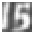

Predicted      1 (1) ✗
Actual         9 (1)
Probability: 1.9800762927769425e-15


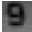

Predicted     42 (2) ✗
Actual        22 (2)
Probability: 7.762314412793616e-14


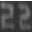

Predicted     42 (2) ✗
Actual        37 (2)
Probability: 1.2250832064866286e-09


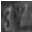

Predicted     42 (2) ✗
Actual        44 (2)
Probability: 5.879583639077354e-13


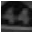

Predicted     12 (2) ✗
Actual        22 (2)
Probability: 2.749313604844581e-12


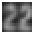

Predicted     16 (2) ✗
Actual        26 (2)
Probability: 1.048051029296277e-10


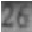

Predicted     55 (2) ✗
Actual        15 (2)
Probability: 1.3481890797865883e-08


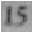

Predicted     07 (2) ✗
Actual        27 (2)
Probability: 4.803431355273791e-25


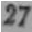

Predicted    409 (3) ✗
Actual       499 (3)
Probability: 7.90848558574925e-09


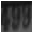

In [87]:
review(x_test, y_test, 10)

Samples:  [7386, 12942, 9240, 9134, 11244, 7677, 13046, 11032, 6436, 6424]
Loss : 2.6879101656430493e-58
Accuracy (single): 50.00% (10/20)
Accuracy (seq): 40.00% (4/10)
Predicted     19 (2) ✗
Actual        15 (2)
Probability: 0.00027003899812769183


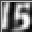

Predicted      2 (1) ✗
Actual         9 (1)
Probability: 0.014924266375601292


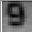

Predicted     42 (2) ✗
Actual        22 (2)
Probability: 0.00012061973990799141


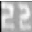

Predicted     42 (2) ✗
Actual        37 (2)
Probability: 0.002854333748881943


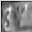

Predicted     44 (2) ✓
Actual        44 (2)
Probability: 0.0005427197747386939


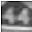

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 0.0011486802579172006


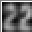

Predicted     14 (2) ✗
Actual        26 (2)
Probability: 0.007708418341071832


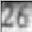

Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.009562323842369214


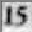

Predicted     27 (2) ✓
Actual        27 (2)
Probability: 8.704687734809263e-06


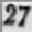

Predicted    670 (3) ✗
Actual       499 (3)
Probability: 0.0012789368961051296


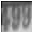

In [23]:
review(x_test, y_test, samples=[ 7386, 12942,  9240,  9134, 11244, 7677, 13046, 11032,  6436,  6424])

Samples:  [7386, 12942, 9240, 9134, 11244, 7677, 13046, 11032, 6436, 6424]
Loss : 4.948103993404499e-58
Accuracy (single): 55.00% (11/20)
Accuracy (seq): 50.00% (5/10)
Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.00033899506180097745


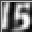

Predicted      1 (1) ✗
Actual         9 (1)
Probability: 0.017832688987255096


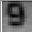

Predicted     42 (2) ✗
Actual        22 (2)
Probability: 8.363393737973379e-05


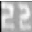

Predicted     22 (2) ✗
Actual        37 (2)
Probability: 0.002733841522818692


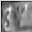

Predicted     44 (2) ✓
Actual        44 (2)
Probability: 0.0003922893439228768


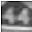

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 0.0005144287047900709


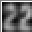

Predicted     15 (2) ✗
Actual        26 (2)
Probability: 0.005797205582314363


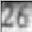

Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.013683930656282595


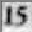

Predicted     27 (2) ✓
Actual        27 (2)
Probability: 1.6789302719735148e-06


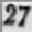

Predicted    670 (3) ✗
Actual       499 (3)
Probability: 0.0012187721975390271


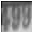

In [36]:
# After 100 Epoch.
review(x_test, y_test, samples=[ 7386, 12942,  9240,  9134, 11244, 7677, 13046, 11032,  6436,  6424])

In [27]:
estimator.save("./svhn/model_20170820.h5")

In [41]:
size = np.argmax( y_pred[0][2] )
num_pred = "".join(map(str, [np.argmax(y_pred[i+1][2]) for i in range(0, 6)] ))
size, num_pred

(2, '000036')

In [37]:
import pandas as pd

In [40]:
pd.DataFrame({"digit_{}".format(i): y_pred[i][2] for i in range(1, 7)})

,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.789899e-20,1.649608e-13
1,0.000000e+00,4.785024e-37,3.266939e-37,1.227559e-31,3.950259e-10,8.727165e-25
2,5.151096e-38,4.241089e-38,2.364325e-38,5.452049e-30,1.029334e-13,7.493147e-20
3,0.000000e+00,0.000000e+00,2.160534e-37,5.836140e-28,9.999993e-01,9.911507e-15
4,9.529929e-36,0.000000e+00,0.000000e+00,0.000000e+00,2.440045e-15,2.488089e-12
5,0.000000e+00,0.000000e+00,4.258877e-37,6.991885e-33,4.485011e-12,2.379972e-05
6,0.000000e+00,0.000000e+00,0.000000e+00,3.829108e-31,2.618382e-10,9.999762e-01
7,0.000000e+00,3.958592e-38,0.000000e+00,0.000000e+00,2.421738e-17,9.985142e-20
8,0.000000e+00,0.000000e+00,0.000000e+00,1.198477e-25,4.880417e-08,2.710925e-09
9,6.165740e-37,0.000000e+00,1.253482e-38,1.030415e-35,6.810179e-07,5.593456e-10


In [42]:
from keras.models import load_model

registered_models = ["./svhn/model_20170807.h5", "./svhn/model_20170810.h5", "./svhn/model_20170813.h5"]

for version in registered_models:
    print("="*5 + " " + version + " " + "="*5)
    modelv = load_model(version)
    y_pred_v = modelv.predict(x_test)
    performance(y_test, y_pred_v)

===== ./svhn/model_20170807.h5 =====
Loss : 0.24274114461189525
Accuracy (single): 37.65% (9801/26032)
Accuracy (seq): 27.25% (3561/13068)
===== ./svhn/model_20170810.h5 =====


/Users/skmohan/.virtualenv/tensorflow/lib/python3.5/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loss : 0.5220275308044474
Accuracy (single): 71.12% (18513/26032)
Accuracy (seq): 57.46% (7509/13068)
